In [ ]:
#################################################################################################
#####################  Assignment 3 MSDS 458 - Analyze AG_News ##################################
#########################      AUthor: Siyuan Liu      ##########################################
##########################   Date: 2022/2/14   ##################################################
#################################################################################################

In [ ]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


### Functions For Research Assignment 

In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Loading AG TensorFlow Dataset

In [ ]:
#register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

2022-02-20 16:39:44.969489: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0220 16:39:44.969802 139651741513600 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0220 16:39:45.391080 139651741513600 dataset_info.py:434] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ag_news_subset/1.0.0
I0220 16:39:46.035097 139651741513600 dataset_info.py:361] Load dataset info from /tmp/tmpn09v0zmetfds
I0220 16:39:46.036532 139651741513600 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0220 16:39:46.036825 139651741513600 dataset_builder.py:357] Generating dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]I0220 16:39:46.477862 139651741513600 download_manager.py:476] 

###  Exploratory Analysis AG News Subset

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [ ]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


In [ ]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
# classes dictionary
categories =dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

In [ ]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

In [ ]:
%%time
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None)
encoder.adapt(dataset_all.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

Cause: could not parse the source code of <function <lambda> at 0x7fbbb918ab00>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fbbb918ab00>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fbbb918ab00>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 31s, sys: 15.1 s, total: 1min 46s
Wall time: 1min 22s


In [ ]:
print(f"There are {len(vocab)} vocabulary words in the corpus.")

There are 95976 vocabulary words in the corpus.


In [ ]:
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U150')

In [ ]:
%%time
doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = encoder(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

CPU times: user 6min 25s, sys: 10.6 s, total: 6min 36s
Wall time: 6min 9s


In [ ]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 3909695 words in the corpus of 127600 news articles.
Each news article has between 3 and 173 tokens in it.


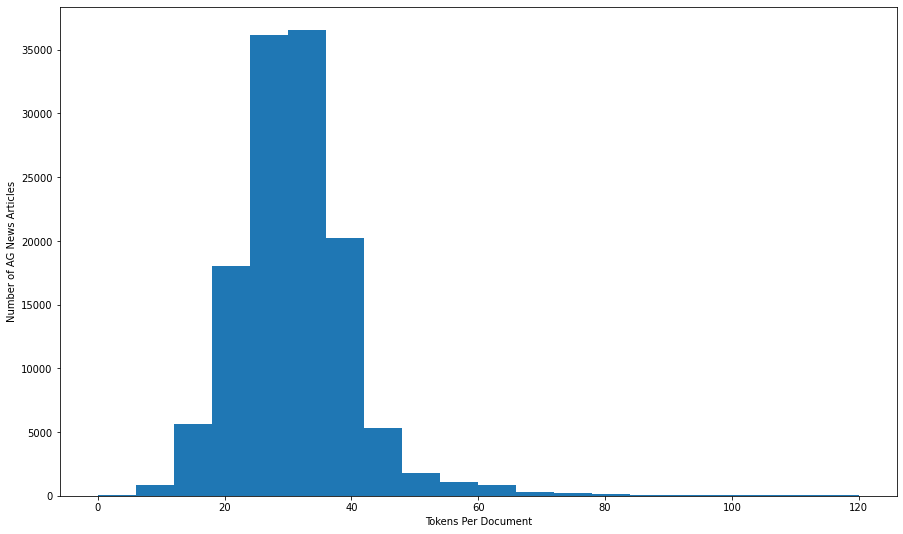

In [ ]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

In [ ]:
%%time
encoder_1000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000)
encoder_1000.adapt(dataset_all.map(lambda text, label: text))
vocab_1000 = np.array(encoder_1000.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7fbbb1c45170>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fbbb1c45170>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fbbb1c45170>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 34s, sys: 15.1 s, total: 1min 49s
Wall time: 1min 21s


In [ ]:
vocab_1000[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

In [ ]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
encoder_1000(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([  2,   1,   1,  29,   3, 232,   1,  14,  19,   1,  18,   2,   1,
         8,   2, 999])>

In [ ]:
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab_1000  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is *not* in the vocabulary.
"ran" is *not* in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is *not* in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is *not* in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is *not* in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


In [ ]:
%%time
doc1000_sizes = []
corpus1000 = []
count1000=0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_1000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 7min 38s, sys: 11.7 s, total: 7min 49s
Wall time: 8min 21s


In [ ]:
print(f"Each news article has between {min(doc1000_sizes)} and {max(doc1000_sizes)} tokens in it.")

Each news article has between 3 and 173 tokens in it.


### Preprocessing Data Create Input Pipeline

In [ ]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2022-02-20 16:58:13.419997: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0220 16:58:13.420202 140541492995968 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0220 16:58:13.421093 140541492995968 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0220 16:58:13.422118 140541492995968 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0220 16:58:13.422289 140541492995968 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.\nComeToMyHead is an academic news search engine which has been running since July, 2004.\nThe dataset is 

In [ ]:
len(train_dataset),len(validation_dataset),len(test_dataset) 
# len(train_dataset),len(test_dataset) 

(114000, 6000, 7600)

### Review Distribution of Categorical Labels for the 114000 training data (news articles)

In [ ]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(2): #take() Creates a Dataset with at most count elements from this dataset, so it returns the data elements (since it's been batched/bundled 64 instances per element)
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b' TOKYO (Reuters) - Nintendo Co. Ltd. raised its 2004  shipment target for its DS handheld video game device by 40  percent to 2.8 million units on Thursday after many stores in  Japan and the United States sold out in the first week of  sales.'
 b"Pakistan's President Pervez Musharraf arrives in London to hold talks with British Prime Minister Tony Blair."
 b"Miami Dolphins general manager Rick Spielman said yesterday he's been assured by owner Wayne Huizenga he will return in that role next season."]

labels:  [2 0 1]
texts:  [b'Iraq #39;s interim government says it will extend the weapons handover program for Sadr City, a Baghdad slum rife with anti-US sentiments, and will soon extend the arms amnesty program nationwide.'
 b'At least 143 people have died in China in flash floods and landslides triggered by torrential rains, the official Xinhua new agency reports.'
 b'The OECD cut its 2005 economic growth forecast for the euro zone and other major economies on Tuesday, blam

In [ ]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b' LYON, France (Reuters) - U.S. Open semi-finalist Joachim  Johansson suffered a surprise defeat by fellow Swede Robin  Soderling at the Lyon Grand Prix Friday.'
 b'Harvard University, unsuccessful in its efforts to buy Kmart out of a Brighton lease as it expands its campus in the area, is using hardball tactics to try to evict the discount store.'
 b' WASHINGTON (Reuters) - U.S. consumers fed a pick-up in U.S.  economic growth in the third quarter but a sentiment survey for  this month showed oil prices were dampening their spirits,  government and private-sector data showed on Friday.']

labels:  ['Sports', 'Business', 'Business']

texts:  [b"When it happens, somehow it will change. It will change by making the remainder of the season more meaningful, extending the dreams of a BCS bowl bid, which is what it's all about at the highest level of college football."
 b'A new variant of the Internet worm MyDoom - Mydoom.Y - has anti-virus vendors puzzled. Not because they can #39

# **Experiment C - Testify Variants of LSTM**

## Create the Text Encoder

1. tweek the vocabulary size of encoder
2. Vocabulary customization
3. output sequence length

In [ ]:
#from the experiment A, we have identified the encoder with 3000 vocab size, unedited vocabulary, and arbitriy 128 output sequence yield the best result

# encoder 1 - 1000 vocabulary size, no edit of vocabulary, default output sequence length
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=3000, output_sequence_length=128)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

3000

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:100]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it',
       'has', 'new', 'an', 'from', 'his', 'us', 'will', 'was', 'reuters',
       'after', 'have', 'be', 'their', 'are', 'over', 'ap', 'he', 'but',
       'two', 'first', 'this', 'more', 'monday', 'wednesday', 'tuesday',
       'thursday', 'company', 'up', 'friday', 'inc', 'one', 'world',
       'yesterday', 'they', 'last', 'york', 'against', 'than', 'about',
       'who', 'not', 'were', 'into', 'year', 'been', 'out', 'president',
       'had', 'when', 'million', 'oil', 'corp', 'united', 'sunday',
       'would', 'which', 'week', 'years', 'today', 'three', 'people',
       'government', 'could', 'quot', 'group', 'no', 'time', 'game',
       'percent', 'saturday', 'software', 'night', 'or', 'iraq', 'prices',
       'next', 'security', 'minister', 'announced', 'some'], dtype='<U21')

Here are the 20 least frequent words.

In [ ]:
vocab[-20:]

array(['barely', 'bar', 'xbox', 'teammate', 'silver', 'secondquarter',
       'referendum', 'quality', 'population', 'plenty', 'palm',
       'operators', 'memphis', 'materials', 'language', 'landing',
       'homeland', 'friendly', 'firsthalf', 'fed'], dtype='<U21')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  68,   19,    1,    1,   19,   26,  699,   19,   26,  699,   18,
         468,    2,    1,    5,    2,  101,   41,    1, 2912,    2,    1,
           5,    3,    1,  811,  277,   75,   16,  153,   13,  108,   58,
          15,    2, 1387, 1053,    5,  864,  300,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   3,   21,    1,    5,    2,  104, 2458,    1,    1,   20, 2732,
        2251,    1,   60,  220,   53,  115,  201,  352, 2298,

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"When it happens, somehow it will change. It will change by making the remainder of the season more meaningful, extending the dreams of a BCS bowl bid, which is what it's all about at the highest level of college football."
Round-trip:  when it [UNK] [UNK] it will change it will change by making the [UNK] of the season more [UNK] extending the [UNK] of a [UNK] bowl bid which is what its all about at the highest level of college football                                                                                        

Original:  b'A new variant of the Internet worm MyDoom - Mydoom.Y - has anti-virus vendors puzzled. Not because they can #39;t do anything about it but because it comes along with a description of itself.'
Round-trip:  a new [UNK] of the internet worm [UNK] [UNK] has antivirus vendors [UNK] not because they can 39t do anything about it but because it comes along with a [UNK] of itself                                                                       

## Create the Model based on same encoder but variant model structure

In [ ]:
#one single layer LSTM

In [ ]:
num_classes = 4
model1 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.LSTM(64) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

## Compile Model 

In [ ]:
model1.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 128)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 128, 64)           192000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 229,444
Trainable params: 229,444
Non-trainable params: 0
__________________________________________________

## Model Trainning

In [ ]:
history1 = model1.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 159s 87ms/step - loss: 0.7640 - accuracy: 0.6817 - val_loss: 0.4593 - val_accuracy: 0.8488
Epoch 2/200
1782/1782 [==============================] - 153s 86ms/step - loss: 0.3993 - accuracy: 0.8694 - val_loss: 0.3690 - val_accuracy: 0.8752
Epoch 3/200
1782/1782 [==============================] - 153s 86ms/step - loss: 0.3372 - accuracy: 0.8860 - val_loss: 0.3385 - val_accuracy: 0.8842
Epoch 4/200
1782/1782 [==============================] - 153s 86ms/step - loss: 0.3077 - accuracy: 0.8943 - val_loss: 0.3299 - val_accuracy: 0.8873
Epoch 5/200
1782/1782 [==============================] - 151s 85ms/step - loss: 0.2921 - accuracy: 0.8992 - val_loss: 0.3284 - val_accuracy: 0.8847
Epoch 6/200
1782/1782 [==============================] - 152s 85ms/step - loss: 0.2827 - accuracy: 0.9022 - val_loss: 0.3211 - val_accuracy: 0.8868


In [ ]:
test_loss, test_acc = model1.evaluate(test_dataset)

119/119 [==============================] - 3s 26ms/step - loss: 0.3312 - accuracy: 0.8839


In [ ]:
history_dict = history1.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.764,0.682,0.459,0.849
1,0.399,0.869,0.369,0.875
2,0.337,0.886,0.338,0.884
3,0.308,0.894,0.330,0.887
4,0.292,0.899,0.328,0.885
5,0.283,0.902,0.321,0.887


In [ ]:
losses = history1.history['loss']
accs = history1.history['accuracy']
val_losses = history1.history['val_loss']
val_accs = history1.history['val_accuracy']
epochs = len(losses)

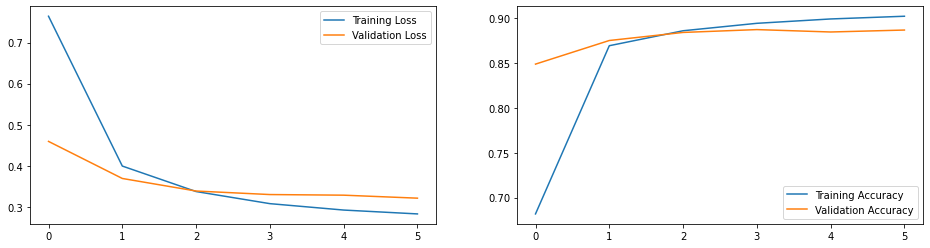

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy = []
test_accuracy.append(test_acc)

In [ ]:
## create model with one bidirection LSTM

In [ ]:
num_classes = 4
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 233s 127ms/step - loss: 0.6633 - accuracy: 0.7596 - val_loss: 0.3988 - val_accuracy: 0.8695
Epoch 2/200
1782/1782 [==============================] - 225s 126ms/step - loss: 0.3577 - accuracy: 0.8774 - val_loss: 0.3442 - val_accuracy: 0.8793
Epoch 3/200
1782/1782 [==============================] - 226s 127ms/step - loss: 0.3114 - accuracy: 0.8917 - val_loss: 0.3205 - val_accuracy: 0.8883
Epoch 4/200
1782/1782 [==============================] - 225s 126ms/step - loss: 0.2906 - accuracy: 0.8979 - val_loss: 0.3185 - val_accuracy: 0.8892
Epoch 5/200
1782/1782 [==============================] - 227s 127ms/step - loss: 0.2787 - accuracy: 0.9016 - val_loss: 0.3189 - val_accuracy: 0.8892
Epoch 6/200
1782/1782 [==============================] - 225s 126ms/step - loss: 0.2715 - accuracy: 0.9040 - val_loss: 0.3131 - val_accuracy: 0.8908
Epoch 7/200
1782/1782 [==============================] - 226s 127ms/step - loss: 0.2657 - accuracy: 0.9058

In [ ]:
test_loss, test_acc = model2.evaluate(test_dataset)

119/119 [==============================] - 4s 31ms/step - loss: 0.3148 - accuracy: 0.8887


In [ ]:
history_dict = history2.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.663,0.760,0.399,0.869
1,0.358,0.877,0.344,0.879
2,0.311,0.892,0.321,0.888
3,0.291,0.898,0.319,0.889
4,0.279,0.902,0.319,0.889
5,0.271,0.904,0.313,0.891
6,0.266,0.906,0.314,0.889
7,0.260,0.908,0.314,0.891


In [ ]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

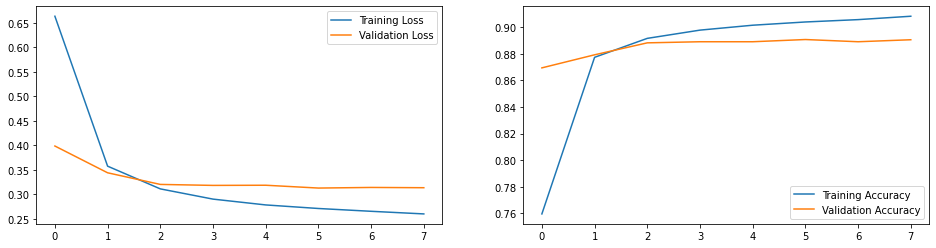

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
## create model with endcoder stacked Bidirectional LSTMs

In [ ]:
num_classes = 4
model3 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model3.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 412s 225ms/step - loss: 0.7229 - accuracy: 0.7162 - val_loss: 0.4222 - val_accuracy: 0.8572
Epoch 2/200
1782/1782 [==============================] - 399s 224ms/step - loss: 0.4206 - accuracy: 0.8642 - val_loss: 0.3736 - val_accuracy: 0.8697
Epoch 3/200
1782/1782 [==============================] - 403s 226ms/step - loss: 0.3775 - accuracy: 0.8790 - val_loss: 0.3539 - val_accuracy: 0.8772
Epoch 4/200
1782/1782 [==============================] - 402s 226ms/step - loss: 0.3548 - accuracy: 0.8862 - val_loss: 0.3484 - val_accuracy: 0.8812
Epoch 5/200
1782/1782 [==============================] - 404s 227ms/step - loss: 0.3379 - accuracy: 0.8902 - val_loss: 0.3387 - val_accuracy: 0.8870
Epoch 6/200
1782/1782 [==============================] - 406s 228ms/step - loss: 0.3222 - accuracy: 0.8956 - val_loss: 0.3278 - val_accuracy: 0.8868
Epoch 7/200
1782/1782 [==============================] - 404s 226ms/step - loss: 0.3086 - accuracy: 0.8998

In [ ]:
test_loss, test_acc = model3.evaluate(test_dataset)

119/119 [==============================] - 7s 57ms/step - loss: 0.3538 - accuracy: 0.8791


In [ ]:
history_dict = history3.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.723,0.716,0.422,0.857
1,0.421,0.864,0.374,0.870
2,0.378,0.879,0.354,0.877
3,0.355,0.886,0.348,0.881
4,0.338,0.890,0.339,0.887
5,0.322,0.896,0.328,0.887
6,0.309,0.900,0.338,0.885


In [ ]:
losses = history3.history['loss']
accs = history3.history['accuracy']
val_losses = history3.history['val_loss']
val_accs = history3.history['val_accuracy']
epochs = len(losses)

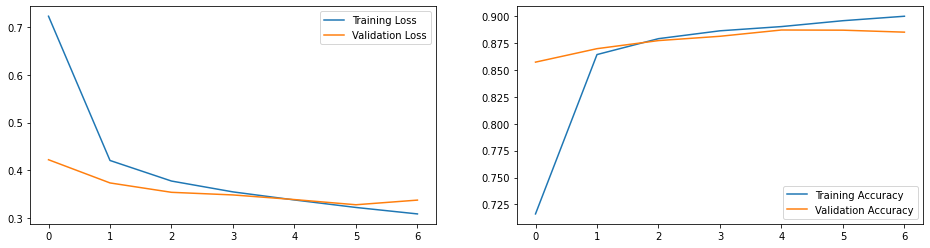

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
## create model with stacked LSTMs layers

In [ ]:
num_classes = 4
model4 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.LSTM(64,  return_sequences=True)
                              ,tf.keras.layers.LSTM(32)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [ ]:
model4.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [ ]:
history4 = model4.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 280s 154ms/step - loss: 0.8156 - accuracy: 0.6391 - val_loss: 0.4630 - val_accuracy: 0.8425
Epoch 2/200
1782/1782 [==============================] - 266s 149ms/step - loss: 0.4437 - accuracy: 0.8554 - val_loss: 0.3944 - val_accuracy: 0.8673
Epoch 3/200
1782/1782 [==============================] - 265s 149ms/step - loss: 0.3964 - accuracy: 0.8712 - val_loss: 0.3835 - val_accuracy: 0.8673
Epoch 4/200
1782/1782 [==============================] - 267s 150ms/step - loss: 0.3781 - accuracy: 0.8775 - val_loss: 0.3747 - val_accuracy: 0.8703
Epoch 5/200
1782/1782 [==============================] - 264s 148ms/step - loss: 0.3620 - accuracy: 0.8831 - val_loss: 0.3623 - val_accuracy: 0.8718
Epoch 6/200
1782/1782 [==============================] - 264s 148ms/step - loss: 0.3424 - accuracy: 0.8895 - val_loss: 0.3532 - val_accuracy: 0.8780
Epoch 7/200
1782/1782 [==============================] - 263s 147ms/step - loss: 0.3280 - accuracy: 0.8947

In [78]:
test_loss, test_acc = model4.evaluate(test_dataset)

119/119 [==============================] - 5s 42ms/step - loss: 0.3376 - accuracy: 0.8851


In [79]:
history_dict = history4.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [80]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
4,0.362,0.883,0.362,0.872
5,0.342,0.889,0.353,0.878
6,0.328,0.895,0.347,0.879
7,0.314,0.898,0.337,0.882
8,0.307,0.900,0.337,0.883
9,0.300,0.902,0.334,0.884
10,0.294,0.904,0.339,0.882
11,0.289,0.905,0.329,0.887
12,0.284,0.907,0.329,0.885
13,0.281,0.907,0.330,0.885


In [81]:
losses = history4.history['loss']
accs = history4.history['accuracy']
val_losses = history4.history['val_loss']
val_accs = history4.history['val_accuracy']
epochs = len(losses)

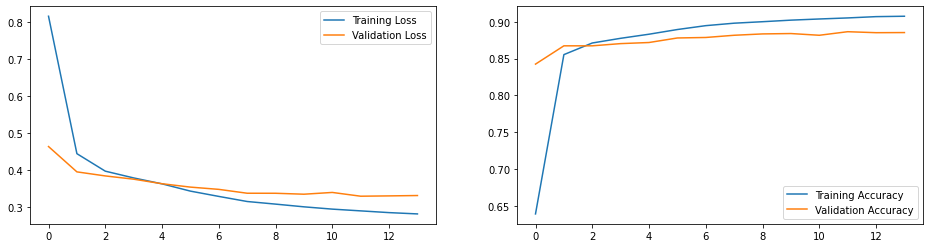

In [82]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [83]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
## create model with stacked LSTMs + Hyperparameter Tuning + Architecture Modification

The fine tune of LSTM models is based on the best model from the prior 4 model experiments of LSTM <br>


*   As a general rule of thumb, one hidden layer will work with most simple problems and two layers with reasonably complex ones. Also, while many nodes (with regularization techniques) within a layer can increase accuracy, fewer number of nodes may cause underfitting
*   Dense nodes
*   Every LSTM layer should be accompanied by a dropout layer. Such a layer helps avoid overfitting in training by bypassing randomly selected neurons, thereby reducing the sensitivity to specific weights of the individual neurons. 








In [86]:
num_classes = 4
model5 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=128
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.LSTM(128, return_sequences=True) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dropout(0.3)
                              ,tf.keras.layers.LSTM(64) 
                              ,tf.keras.layers.Dropout(0.3)
                              ,tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001))
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [87]:
model5.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [89]:
history5 = model5.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 512s 283ms/step - loss: 0.6701 - accuracy: 0.7591 - val_loss: 0.4330 - val_accuracy: 0.8675
Epoch 2/200
1782/1782 [==============================] - 506s 284ms/step - loss: 0.4027 - accuracy: 0.8781 - val_loss: 0.3923 - val_accuracy: 0.8757
Epoch 3/200
1782/1782 [==============================] - 511s 286ms/step - loss: 0.3589 - accuracy: 0.8888 - val_loss: 0.3855 - val_accuracy: 0.8728
Epoch 4/200
1782/1782 [==============================] - 513s 288ms/step - loss: 0.3360 - accuracy: 0.8934 - val_loss: 0.3600 - val_accuracy: 0.8847
Epoch 5/200
1782/1782 [==============================] - 503s 282ms/step - loss: 0.3197 - accuracy: 0.8973 - val_loss: 0.3528 - val_accuracy: 0.8820
Epoch 6/200
1782/1782 [==============================] - 501s 281ms/step - loss: 0.3088 - accuracy: 0.8989 - val_loss: 0.3526 - val_accuracy: 0.8827


In [90]:
test_loss, test_acc = model5.evaluate(test_dataset)

119/119 [==============================] - 11s 96ms/step - loss: 0.3547 - accuracy: 0.8853


In [91]:
history_dict = history5.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [92]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.670,0.759,0.433,0.868
1,0.403,0.878,0.392,0.876
2,0.359,0.889,0.385,0.873
3,0.336,0.893,0.360,0.885
4,0.320,0.897,0.353,0.882
5,0.309,0.899,0.353,0.883


In [93]:
losses = history5.history['loss']
accs = history5.history['accuracy']
val_losses = history5.history['val_loss']
val_accs = history5.history['val_accuracy']
epochs = len(losses)

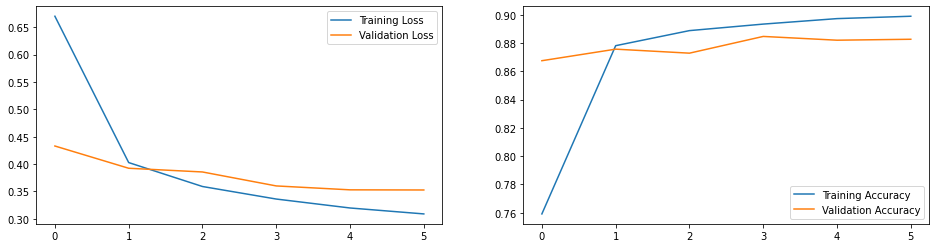

In [94]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [95]:
# track the test performance
test_accuracy.append(test_acc)

In [ ]:
## create model with one bidirectional LSTM layers + increased input dimension + L2 regularizer

In [101]:
num_classes = 4
model6 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=128
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)) #128 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001))
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [102]:
model6.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [103]:
history6 = model6.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 918s 508ms/step - loss: 0.6128 - accuracy: 0.7953 - val_loss: 0.4115 - val_accuracy: 0.8815
Epoch 2/200
1782/1782 [==============================] - 903s 507ms/step - loss: 0.3950 - accuracy: 0.8818 - val_loss: 0.3747 - val_accuracy: 0.8838
Epoch 3/200
1782/1782 [==============================] - 910s 511ms/step - loss: 0.3502 - accuracy: 0.8943 - val_loss: 0.3556 - val_accuracy: 0.8868
Epoch 4/200
1782/1782 [==============================] - 918s 515ms/step - loss: 0.3227 - accuracy: 0.9001 - val_loss: 0.3593 - val_accuracy: 0.8845
Epoch 5/200
1782/1782 [==============================] - 918s 515ms/step - loss: 0.3032 - accuracy: 0.9036 - val_loss: 0.3397 - val_accuracy: 0.8885
Epoch 6/200
1782/1782 [==============================] - 915s 513ms/step - loss: 0.2888 - accuracy: 0.9070 - val_loss: 0.3362 - val_accuracy: 0.8888
Epoch 7/200
1782/1782 [==============================] - 922s 517ms/step - loss: 0.2765 - accuracy: 0.9105

In [104]:
test_loss, test_acc = model6.evaluate(test_dataset)

119/119 [==============================] - 19s 158ms/step - loss: 0.3464 - accuracy: 0.8838


In [105]:
history_dict = history6.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [106]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.613,0.795,0.411,0.882
1,0.395,0.882,0.375,0.884
2,0.350,0.894,0.356,0.887
3,0.323,0.900,0.359,0.885
4,0.303,0.904,0.340,0.888
5,0.289,0.907,0.336,0.889
6,0.276,0.911,0.335,0.890
7,0.268,0.913,0.340,0.887
8,0.259,0.915,0.337,0.887


In [107]:
losses = history6.history['loss']
accs = history6.history['accuracy']
val_losses = history6.history['val_loss']
val_accs = history6.history['val_accuracy']
epochs = len(losses)

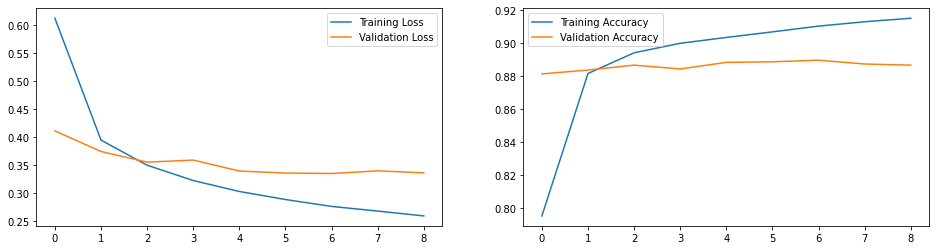

In [108]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [109]:
# track the test performance
test_accuracy.append(test_acc)

In [110]:
model_name =['model1','model2','model3','model4','model5','model6']
model_descr =['1 LSTM (64), 1 DNN (64)',
              '1 Bidirectional LSTM (64), 1 DNN (64)',
              '2 Stacked Bidirectional LSTM (64, 32), Dropout (0.5), 1 DNN (64)',
              '2 Stacked LSTM (64, 32), Dropout (0.5), 1 DNN (64)',
              '2 Stacked LSTM (128, 64), 2 Dropout (0.3), 1 DNN (64), L2 Regularizer (0.001)',
              '2 Stacked Bidirectional LSTM (128, 64), 2 Dropout (0.5), 1 DNN (64), L2 Regularizer (0.001)'
             ]

In [111]:
perf_dict = { 'model' : model_name,
              'description': model_descr,
              'test_accuracy': test_accuracy
}

df_perf = pd.DataFrame(perf_dict)
print(df_perf)

    model                                        description  test_accuracy
0  model1                            1 LSTM (64), 1 DNN (64)       0.883947
1  model2              1 Bidirectional LSTM (64), 1 DNN (64)       0.888684
2  model3  2 Stacked Bidirectional LSTM (64, 32), Dropout...       0.879079
3  model4  2 Stacked LSTM (64, 32), Dropout (0.5), 1 DNN ...       0.885132
4  model5  2 Stacked LSTM (128, 64), 2 Dropout (0.3), 1 D...       0.885263
5  model6  2 Stacked Bidirectional LSTM (128, 64), 2 Drop...       0.883816


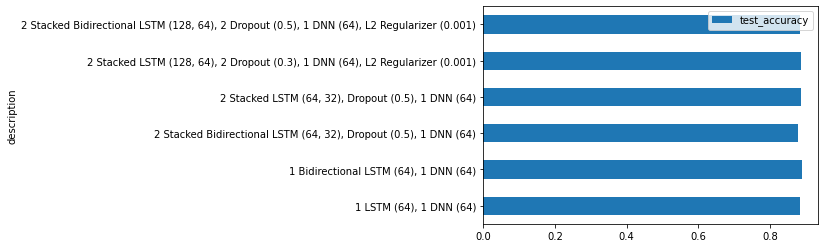

In [112]:
df_perf.plot.barh(x='description', y='test_accuracy')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
%%shell
jupyter nbconvert --to html /content/gdrive/MyDrive/458_AI/Assignment3/Liu_Assignment3_Part1.ipynb

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/458_AI/Assignment3/Liu_Assignment3_Part1.ipynb to html
[NbConvertApp] Writing 1136522 bytes to /content/gdrive/MyDrive/458_AI/Assignment3/Liu_Assignment3_Part1.html
